In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
from scipy import signal

import numpy as np
import pandas as pd

import os

import glob
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from mvee import EllipsoidTool as ET

In [13]:
wsrc = '../hpcc/clean/'
dst =  '../hpcc/rotated/'

#wsrc = '../clean2/'
#dst =  '../rotated/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1
walnut_batch = sorted(glob.glob( wsrc + '*/' ))
bidx = 2
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))

bname = walnut_batch[bidx].split('/')[-2]

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

for i in range(len(walnut_files)):
    print(i, os.path.split(walnut_files[i])[1], sep='\t')

../hpcc/rotated/2012SB_R12_T62/
0	2012SB_R12_T62_001.tif
1	2012SB_R12_T62_002.tif
2	2012SB_R12_T62_003.tif
3	2012SB_R12_T62_004.tif
4	2012SB_R12_T62_005.tif


In [14]:
widx = 3
print(walnut_files[widx])

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

img = tf.imread(walnut_files[widx])
mxval = 2**(8*img.itemsize)

nutvol = np.sum(img > 0) * (resol ** 3)

../hpcc/clean/2012SB_R12_T62/2012SB_R12_T62_004.tif
2012SB_R12_T62_004


In [20]:
filename = wdst + fname + '_rotation.csv'
print(filename)
data = np.loadtxt(filename, delimiter=',')

wmean = data[0]
rotxyz = data[10:13]
rotX, rotY, rotZ = data[13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
chnutarea, chnutvol, _ = data[20]

if rotX == 1:
    tipvox[0] *= -1.

../hpcc/rotated/2012SB_R12_T62/2012SB_R12_T62_004_rotation.csv


# Verify rotation

In [16]:
bimg = img.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
border[border > 0] = 1

datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

Tip coords:	 [19.71  0.03 -0.05]


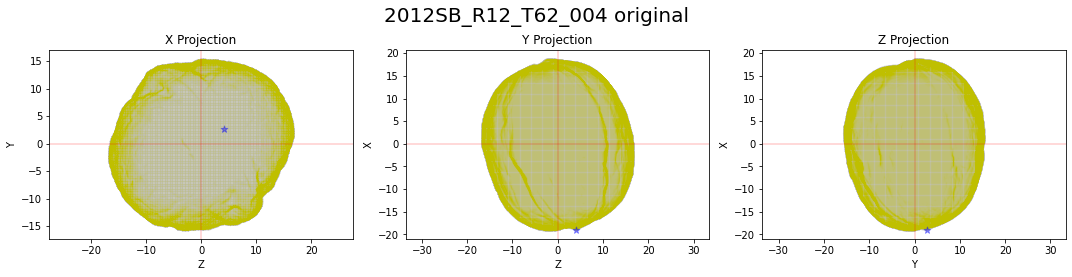

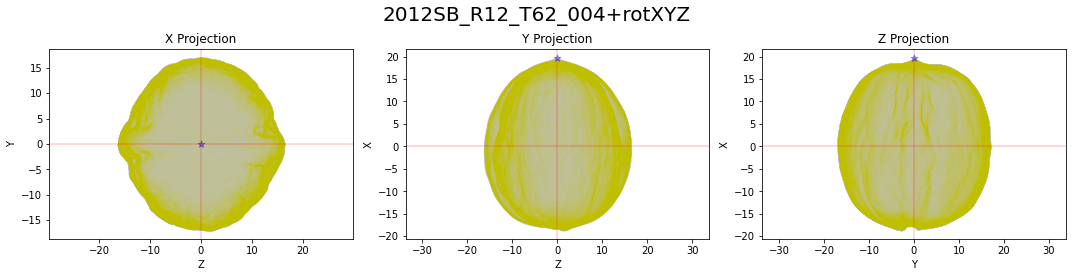

In [21]:
rcoords = rotxyz @ datapoints
print('Tip coords:\t', np.round(rtipvox, 2))

fig, ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='b', alpha=.4);

fig, ax = wnut.plot_3Dprojections(rcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

### Alignment